# Analysis of the data

This notebook will handle the data by reading, preprocessing and visualising it. We start by importing libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import datetime

Now we read the sampled data file `mixed_sample.csv`

In [2]:
df = pd.read_csv("../cases/mixed_sample.csv")
df.head()

,Unnamed: 0,ddl_case_id,year,state_code,dist_code,court_no,cino,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name,date_of_filing,date_of_decision,date_first_list,date_last_list,date_next_list
0,0,01-01-01-201908000082010,2010,1,1,1,MHNB030000332010,chief judicial magistrate,0 male,1 female,-9999,-9998,1429,3006.0,25,2010-01-13,2011-10-03,2010-01-28,2011-09-19,2011-10-03
1,1,01-01-01-201908000272010,2010,1,1,1,MHNB030001492010,chief judicial magistrate,-9998 unclear,1 female,-9999,-9998,1429,3627.0,25,2010-02-18,2010-03-20,2010-02-22,2010-03-05,2010-03-20
2,2,01-01-01-201908000352010,2010,1,1,1,MHNB030002532010,chief judicial magistrate,-9998 unclear,0 male,-9998,1,1429,2237.0,25,2010-03-17,2010-03-29,2010-03-19,2010-03-23,2010-03-26
3,3,01-01-01-201908000562010,2010,1,1,1,MHNB030005102010,chief judicial magistrate,-9998 unclear,0 male,-9999,0,1429,3734.0,22,2010-04-26,2015-06-11,2010-06-07,2015-05-29,2015-06-11
4,4,01-01-01-201908000722010,2010,1,1,1,MHNB030004912010,chief judicial magistrate,0 male,1 female,-9999,-9998,1429,3734.0,25,2010-05-29,2010-06-09,2010-06-02,2010-06-07,2010-06-09


We also read the judges csv.

In [3]:
judge_df = pd.read_csv("../judges_clean.csv")
judge_df.head()

,ddl_judge_id,state_code,dist_code,court_no,judge_position,female_judge,start_date,end_date
0,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014
1,2,1,1,1,chief judicial magistrate,0 nonfemale,31-10-2013,20-02-2014
2,3,1,1,1,chief judicial magistrate,0 nonfemale,21-02-2014,31-05-2016
3,4,1,1,1,chief judicial magistrate,0 nonfemale,01-06-2016,06-06-2016
4,5,1,1,1,chief judicial magistrate,0 nonfemale,06-06-2016,07-07-2018


We read a few key csv files to merge later.

In [4]:
disp_frame = pd.read_csv("../keys/disp_name_key.csv")[['year', 'disp_name', 'disp_name_s']]
state_frame = pd.read_csv("../keys/cases_state_key.csv")[['year', 'state_code', 'state_name']]
district_frame = pd.read_csv("../keys/cases_district_key.csv")[['year', 'state_code', 'dist_code', 'district_name']]
court_frame = pd.read_csv("../keys/cases_court_key.csv")[['year', 'state_code', 'dist_code', 'court_no', 'court_name']]
purpose_frame = pd.read_csv("../keys/purpose_name_key.csv")
pd.options.display.max_rows = 10

We use geopandas to read a geopandas dataframe for plotting maps.

In [5]:
shp_gdf = gpd.read_file('../stanford-mw277wc3858-shapefile/mw277wc3858.shp')
shp_gdf.replace('Odisha', 'Orissa', inplace=True)
shp_gdf.replace('NCT of Delhi', 'Delhi', inplace=True)
shp_gdf.set_index('name_1', inplace=True)
shp_gdf.head()

,id_0,iso,name_0,id_1,hasc_1,ccn_1,cca_1,type_1,engtype_1,nl_name_1,varname_1,geometry
name_1,,,,,,,,,,,,
Andaman and Nicobar,105.0,IND,India,1.0,IN.AN,0.0,None,Union Territor,Union Territory,None,Andaman & Nicobar Islands|Andaman et Nicobar|I...,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."
Andhra Pradesh,105.0,IND,India,2.0,IN.AP,0.0,None,State,State,None,None,"MULTIPOLYGON (((80.19264 13.52070, 80.19264 13..."
Arunachal Pradesh,105.0,IND,India,3.0,IN.AR,0.0,None,State,State,None,Agence de la Frontière du Nord-Est(French-obso...,"POLYGON ((96.15778 29.38310, 96.16380 29.37668..."
Assam,105.0,IND,India,4.0,IN.AS,0.0,None,State,State,None,None,"MULTIPOLYGON (((89.87145 25.53730, 89.87118 25..."
Bihar,105.0,IND,India,5.0,IN.BR,0.0,None,State,State,None,None,"MULTIPOLYGON (((88.10548 26.53904, 88.10505 26..."


## Preprocessing the data

Here we preprocess the data to remove entries with erroneous or missing values. We will not remove entries with missing gender values, that will be done when required since those cases are frequent.

We remove erroneous date values, and convert the rest to datetime objects.

In [6]:
df.date_of_decision = pd.to_datetime(df.date_of_decision, errors='coerce')
df.date_of_filing = pd.to_datetime(df.date_of_filing, errors='coerce')
df.date_first_list = pd.to_datetime(df.date_first_list, errors='coerce')
df.date_last_list = pd.to_datetime(df.date_last_list, errors='coerce')
df.date_next_list = pd.to_datetime(df.date_next_list, errors='coerce')
df.dropna()

,Unnamed: 0,ddl_case_id,year,state_code,dist_code,court_no,cino,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name,date_of_filing,date_of_decision,date_first_list,date_last_list,date_next_list
0,0,01-01-01-201908000082010,2010,1,1,1,MHNB030000332010,chief judicial magistrate,0 male,1 female,-9999,-9998,1429,3006.0,25,2010-01-13,2011-10-03,2010-01-28,2011-09-19,2011-10-03
1,1,01-01-01-201908000272010,2010,1,1,1,MHNB030001492010,chief judicial magistrate,-9998 unclear,1 female,-9999,-9998,1429,3627.0,25,2010-02-18,2010-03-20,2010-02-22,2010-03-05,2010-03-20
2,2,01-01-01-201908000352010,2010,1,1,1,MHNB030002532010,chief judicial magistrate,-9998 unclear,0 male,-9998,1,1429,2237.0,25,2010-03-17,2010-03-29,2010-03-19,2010-03-23,2010-03-26
3,3,01-01-01-201908000562010,2010,1,1,1,MHNB030005102010,chief judicial magistrate,-9998 unclear,0 male,-9999,0,1429,3734.0,22,2010-04-26,2015-06-11,2010-06-07,2015-05-29,2015-06-11
4,4,01-01-01-201908000722010,2010,1,1,1,MHNB030004912010,chief judicial magistrate,0 male,1 female,-9999,-9998,1429,3734.0,25,2010-05-29,2010-06-09,2010-06-02,2010-06-07,2010-06-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,99995,32-01-01-210720001562014,2014,32,1,1,UTDN010006742014,principal district and sessions court,-9998 unclear,-9998 unclear,0,-9998,5714,2821.0,4,2014-07-17,2017-09-26,2014-12-10,2017-09-26,2017-09-26
499996,99996,32-01-01-211000000212014,2014,32,1,1,UTDN010000972014,principal district and sessions court,0 male,-9998 unclear,0,-9999,5698,5487.0,22,2014-01-30,2018-11-16,2014-04-02,2018-11-16,2018-11-16
499997,99997,32-01-01-211020002412014,2014,32,1,1,UTDN010010912014,principal district and sessions court,0 male,-9998 unclear,-9999,-9998,5698,5487.0,24,2014-12-03,2014-12-03,2014-12-03,2014-12-03,2014-12-03
499998,99998,32-01-01-211420000082014,2014,32,1,1,UTDN010005002014,principal district and sessions court,0 male,1 female,-9999,0,3628,6434.0,24,2014-06-10,2014-11-28,2014-07-01,2014-11-27,2014-11-28


In [7]:
judge_df.start_date = pd.to_datetime(judge_df.start_date, errors='coerce', dayfirst=True)
judge_df.end_date = pd.to_datetime(judge_df.end_date, errors='coerce', dayfirst=True)
judge_df.dropna()

,ddl_judge_id,state_code,dist_code,court_no,judge_position,female_judge,start_date,end_date
0,1,1,1,1,chief judicial magistrate,0 nonfemale,2013-09-20,2014-02-20
1,2,1,1,1,chief judicial magistrate,0 nonfemale,2013-10-31,2014-02-20
2,3,1,1,1,chief judicial magistrate,0 nonfemale,2014-02-21,2016-05-31
3,4,1,1,1,chief judicial magistrate,0 nonfemale,2016-06-01,2016-06-06
4,5,1,1,1,chief judicial magistrate,0 nonfemale,2016-06-06,2018-07-07
...,...,...,...,...,...,...,...,...
98471,98472,30,2,8,criminal cases,1 female,2016-04-04,2016-12-15
98473,98474,30,2,9,criminal cases,1 female,2004-04-21,2013-11-14
98474,98475,30,2,9,criminal cases,1 female,2015-01-16,2016-01-16
98475,98476,30,2,9,criminal cases,1 female,2016-12-09,2017-07-31


We also convert all gender fields to have similar type of data.

In [8]:
def clean_gender_1(row):
    if row == '0 male' or row == '0 nonfemale':
        row = 0
    elif row == '1 female':
        row = 1
    elif row == '-9999 missing name':
        row = -9999
    elif row == '-9998 unclear':
        row = -9998
    else:
        row = np.NaN

    return row

df.female_defendant = [clean_gender_1(row) for row in df.female_defendant]
df.female_petitioner = [clean_gender_1(row) for row in df.female_petitioner]
df.dropna()     

judge_df.female_judge = [clean_gender_1(row) for row in judge_df.female_judge]
judge_df.dropna()

,ddl_judge_id,state_code,dist_code,court_no,judge_position,female_judge,start_date,end_date
0,1,1,1,1,chief judicial magistrate,0.0,2013-09-20,2014-02-20
1,2,1,1,1,chief judicial magistrate,0.0,2013-10-31,2014-02-20
2,3,1,1,1,chief judicial magistrate,0.0,2014-02-21,2016-05-31
3,4,1,1,1,chief judicial magistrate,0.0,2016-06-01,2016-06-06
4,5,1,1,1,chief judicial magistrate,0.0,2016-06-06,2018-07-07
...,...,...,...,...,...,...,...,...
98471,98472,30,2,8,criminal cases,1.0,2016-04-04,2016-12-15
98473,98474,30,2,9,criminal cases,1.0,2004-04-21,2013-11-14
98474,98475,30,2,9,criminal cases,1.0,2015-01-16,2016-01-16
98475,98476,30,2,9,criminal cases,1.0,2016-12-09,2017-07-31


## Analysing the Data

We start by plotting the state wise distribution of the cases. We define a funciton to plot maps below for later use.

In [9]:
def plot_map(merged, column, title):
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.axis('off')
    ax.set_title(title,
                fontdict={'fontsize': '15', 'fontweight' : '3'})
    fig = merged.plot(column=column, cmap='OrRd', linewidth=0.5, ax=ax, edgecolor='0.2',legend=True, missing_kwds={'color':'lightgrey'})

### Judge analysis

We first look at the %age of judges that are female in each state

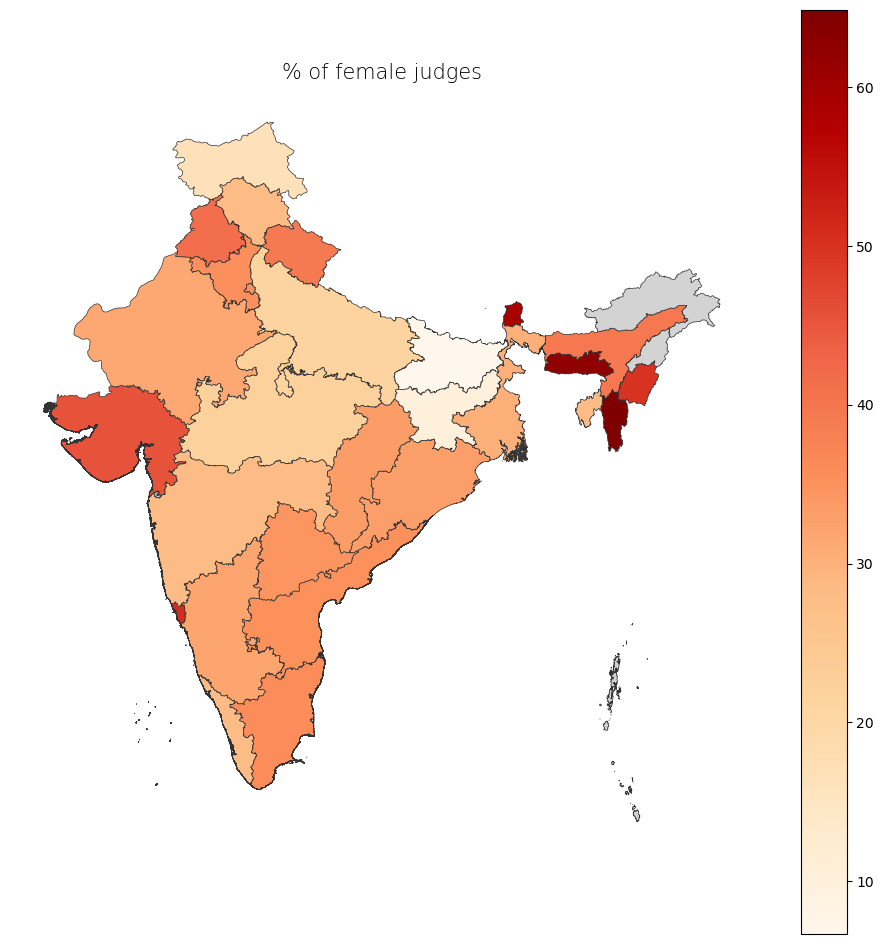

In [10]:
judge_df_clean = pd.merge(judge_df[judge_df['female_judge'] != -9998], state_frame)
S = judge_df_clean.groupby('state_name').agg({'female_judge' : 'sum'})*100 / judge_df_clean.groupby('state_name').agg({'female_judge' : 'count'})
plot_map(shp_gdf.join(S), 'female_judge', '% of female judges')

We can see that north eastern states have more proportion of female judges. We can see this pattern in female advocates as well.

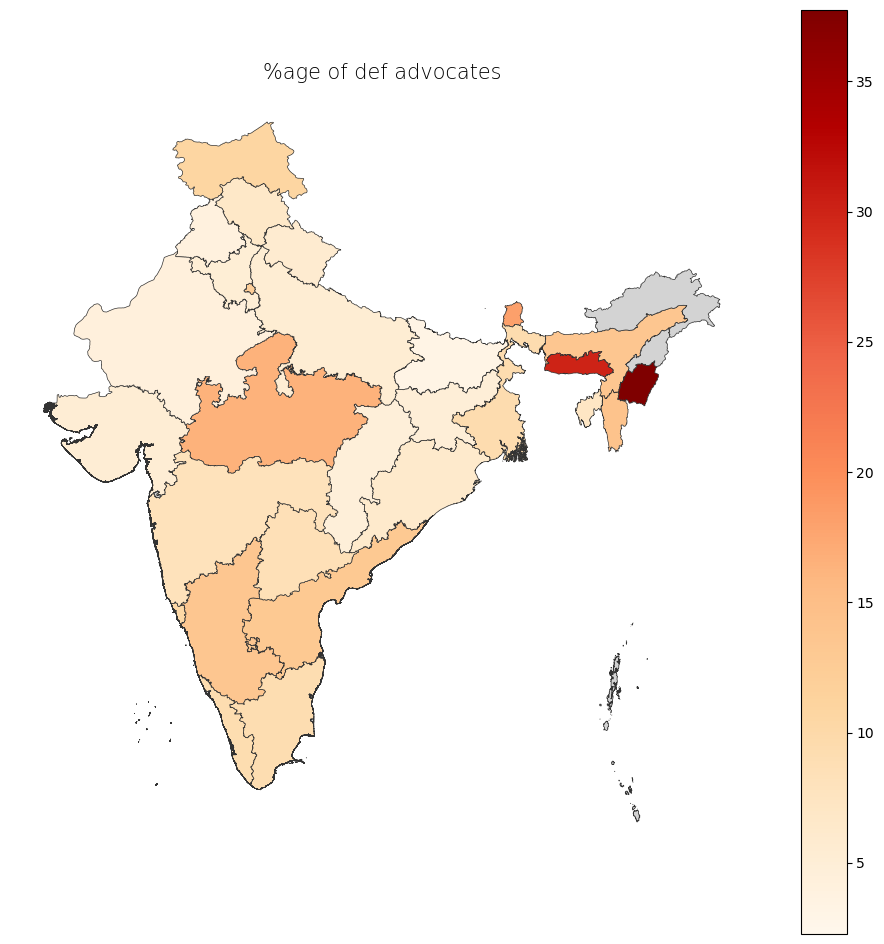

In [11]:
S1 = pd.merge(df, state_frame).replace({'female_adv_def':{-9999:np.NaN, -9998:np.NaN}}).dropna().groupby('state_name')
S = S1.agg({'female_adv_def':'sum'})*100/S1.agg({'female_adv_def':'count'})
plot_map(shp_gdf.join(S), 'female_adv_def', '%age of def advocates')

We can also see some common judge positions have very low rates of female judges.

In [12]:
group_judge = judge_df.replace(-9998, np.NaN).dropna().groupby('judge_position').filter(lambda x: len(x) > 1000).groupby('judge_position')
S = group_judge.agg({'female_judge':'sum'})*100 / group_judge.agg({'female_judge':'count'})
S.sort_values(by='female_judge',ascending=True, inplace=True)
S.rename(columns={'female_judge':'percentage of judges who are female'}, inplace=True)
S.head(10)

,percentage of judges who are female
judge_position,
additional district and sessions court,10.781476
additional district judge,11.691542
district and sessions court,16.808086
principal district and sessions court,20.601504
family court,22.832140
small cause court,24.798568
civil court,31.329888
civil judge senior division,32.298358
judicial magistrate court,33.492647


### Case Type Analysis - Gender

We analyse here the types of cases that are in the database. For that we read the type_name_key.csv and merge it.

In [13]:
type_frame = pd.read_csv("../keys/type_name_key.csv")
df_type = pd.merge(df, type_frame, on=['type_name', 'year'])
df_type.head()

,Unnamed: 0,ddl_case_id,year,state_code,dist_code,court_no,cino,judge_position,female_defendant,female_petitioner,...,type_name,purpose_name,disp_name,date_of_filing,date_of_decision,date_first_list,date_last_list,date_next_list,type_name_s,count
0,0,01-01-01-201908000082010,2010,1,1,1,MHNB030000332010,chief judicial magistrate,0,1,...,1429,3006.0,25,2010-01-13,2011-10-03,2010-01-28,2011-09-19,2011-10-03,cri.m.a.,66722
1,1,01-01-01-201908000272010,2010,1,1,1,MHNB030001492010,chief judicial magistrate,-9998,1,...,1429,3627.0,25,2010-02-18,2010-03-20,2010-02-22,2010-03-05,2010-03-20,cri.m.a.,66722
2,2,01-01-01-201908000352010,2010,1,1,1,MHNB030002532010,chief judicial magistrate,-9998,0,...,1429,2237.0,25,2010-03-17,2010-03-29,2010-03-19,2010-03-23,2010-03-26,cri.m.a.,66722
3,3,01-01-01-201908000562010,2010,1,1,1,MHNB030005102010,chief judicial magistrate,-9998,0,...,1429,3734.0,22,2010-04-26,2015-06-11,2010-06-07,2015-05-29,2015-06-11,cri.m.a.,66722
4,4,01-01-01-201908000722010,2010,1,1,1,MHNB030004912010,chief judicial magistrate,0,1,...,1429,3734.0,25,2010-05-29,2010-06-09,2010-06-02,2010-06-07,2010-06-09,cri.m.a.,66722


By plotting a bar chart we can see that in case of criminal cases, women make up less percentage of the defendants than in other major cases (original suit, ep). Here we only consider major case types using a filter.

<AxesSubplot: title={'center': '%age of women defendants in cases'}>

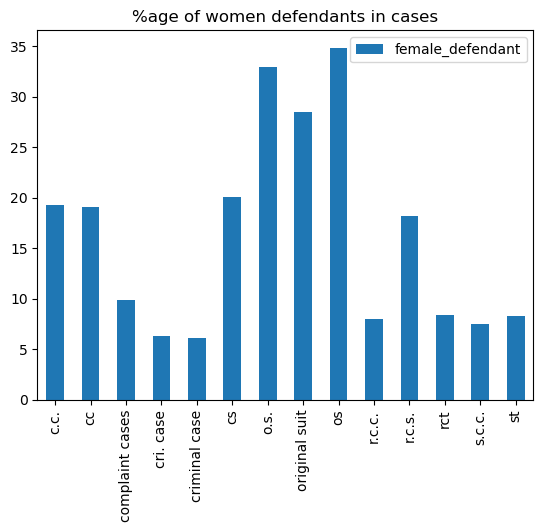

In [14]:
df_type_clean = df_type[df_type['female_defendant']>=0].groupby('type_name_s').filter(lambda x: len(x) > 5000)
S = df_type_clean.groupby('type_name_s').agg({'female_defendant':'sum'})*100 / df_type_clean.groupby('type_name_s').agg({'female_defendant':'count'})
# S.sort_values(by='female_defendant', ascending=False)
S.plot(kind='bar', y='female_defendant', title='%age of women defendants in cases', xlabel="")

### Disposition Analysis

We analyse the dispositions of court cases. First we can see the msot commonly encountered case dispositions:

In [15]:
pd.merge(df, disp_frame, on=['year', 'disp_name']).disp_name_s.value_counts().head(15)

disposition var missing    76172
dismissed                  61508
acquitted                  41778
allowed                    36193
disposed                   34769
                           ...  
referred to lok adalat     17422
withdrawn                  17395
compromise                 13425
fine                        9900
closed                      9108
Name: disp_name_s, Length: 15, dtype: int64

Here we can see some common dispositions - acquitted, dismissed, convicted. We can now group them by disposition to see the average duration of a case.

<AxesSubplot: xlabel='disp_name_s'>

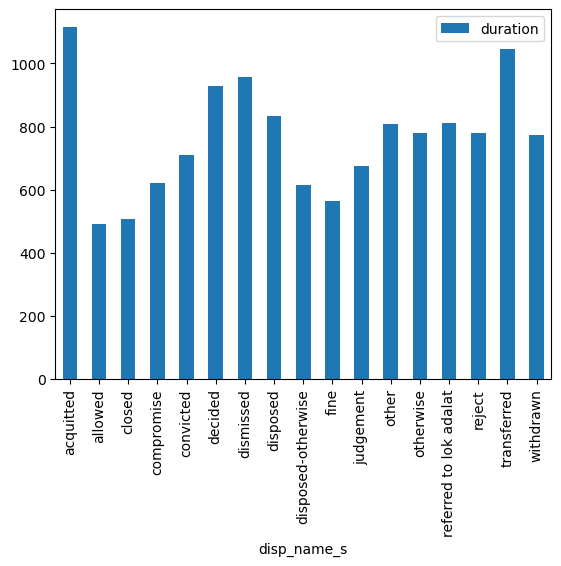

In [16]:
df['duration'] = (df.date_of_decision - df.date_of_filing).dt.days
df = df[df['duration'] > 0]
# pd.merge(df, disp_frame, on=['year', 'disp_name']).groupby('disp_name_s').agg({'duration':'mean'}).sort_values(by='duration')
df_disp = pd.merge(df, disp_frame, on=['year', 'disp_name']).groupby('disp_name_s').filter(lambda x : len(x)>5000)
df_disp.groupby('disp_name_s').agg({'duration':'mean'}).plot(kind='bar')

Here we see on avergae it takes longer for a court case to rule for acquittal or dismissed than for conviction. However acquittals and dismissals are more common than convictions.

<AxesSubplot: ylabel='disp_name_s'>

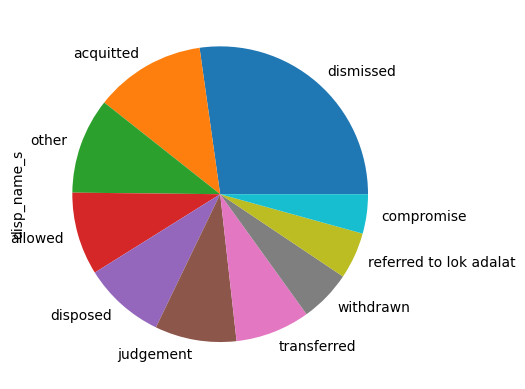

In [18]:
# df_disp = df_disp.replace({'female_defendant':{-9999:np.NaN, -9998:np.NaN}}).dropna()
df_disp_fem = df_disp[df_disp['female_defendant'] == 1]
df_disp_fem.disp_name_s.value_counts()[:10].plot(kind='pie')

<AxesSubplot: ylabel='disp_name_s'>

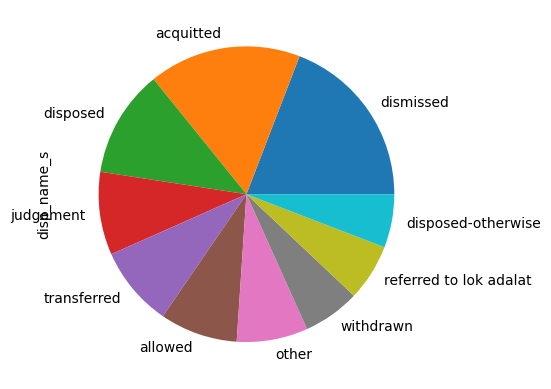

In [19]:
# df_disp = df_disp.replace({'female_defendant':{-9999:np.NaN, -9998:np.NaN}}).dropna()
df_disp_nonfem = df_disp[df_disp['female_defendant'] == 0]
df_disp_nonfem.disp_name_s.value_counts()[:10].plot(kind='pie')

We can see above that when the defendant is female, she is more likely to be acquitted

In [1]:
df_dispclean = df_disp.groupby('disp_name').size()

NameError: name 'df_disp' is not defined